# SG-FIGS: Final Integrated Research Synthesis — Evaluation Demo

This notebook demonstrates the **comprehensive evaluation pipeline** for Synergy-Guided FIGS (SG-FIGS), synthesizing results from 4 experiments across 14 datasets and 5 methods.

**What this artifact does:**
- Builds a master results table (14 datasets x 5 methods) with balanced accuracy and AUC
- Runs statistical significance tests (Friedman, pairwise Wilcoxon with Holm-Bonferroni correction)
- Computes ablation analysis (SG-FIGS-Hard vs Random-FIGS)
- Compares interpretability scores across methods
- Analyzes threshold sensitivity and cross-experiment consistency
- Evaluates PID-performance correlation and hypothesis verdict
- Generates publication-ready LaTeX tables

In [1]:
%%capture
%pip install -q --force-reinstall numpy==1.26.4 pandas==2.3.3 scipy==1.15.3 matplotlib==3.10.7

In [2]:
import json
import warnings

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-fb8249-synergy-guided-oblique-splits-using-part/main/evaluation_iter4_sg_figs_eval/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded evaluation data: {data['metadata']['evaluation_name']}")
print(f"Datasets in output: {len(data['datasets'])}")
print(f"Total examples: {sum(len(d['examples']) for d in data['datasets'])}")

Loaded evaluation data: SG-FIGS Final Integrated Research Synthesis
Datasets in output: 10
Total examples: 67


## Configuration

Method labels and display settings used throughout the evaluation.

In [5]:
METHODS_5 = ["figs", "ro_figs", "sg_figs_hard", "sg_figs_soft", "random_figs"]
METHOD_LABELS = {
    "figs": "FIGS",
    "ro_figs": "RO-FIGS",
    "sg_figs_hard": "SG-FIGS-Hard",
    "sg_figs_soft": "SG-FIGS-Soft",
    "random_figs": "Random-FIGS",
}

# Build lookup for datasets by name
ds_lookup = {d["dataset"]: d for d in data["datasets"]}

## 1. Aggregate Metrics Overview

Display the pre-computed aggregate metrics from the full evaluation (14 datasets, 5 methods).

In [6]:
metrics = data["metrics_agg"]

print("=== Grand Mean Balanced Accuracy (14 datasets, 5-fold CV) ===")
for m in METHODS_5:
    key = f"grand_mean_ba_{m}"
    rank_key = f"avg_rank_{m}"
    print(f"  {METHOD_LABELS[m]:15s}: BA={metrics[key]:.4f}  AvgRank={metrics[rank_key]:.2f}")

print(f"\n=== Statistical Tests ===")
print(f"  Friedman chi2 = {metrics['friedman_chi2']:.4f}, p = {metrics['friedman_p']:.6f}")

print(f"\n=== Ablation (SG-FIGS-Hard vs Random-FIGS) ===")
print(f"  Mean accuracy delta:        {metrics['ablation_mean_acc_delta']:+.4f}")
print(f"  Mean interpretability delta: {metrics['ablation_mean_interp_delta']:+.4f}")

print(f"\n=== Hypothesis Verdict ===")
verdict = data["metadata"]["hypothesis_verdict"]
print(f"  {verdict['summary']}")
print(f"  Hypothesis supported: {verdict['hypothesis_supported']}")

=== Grand Mean Balanced Accuracy (14 datasets, 5-fold CV) ===
  FIGS           : BA=0.7865  AvgRank=3.36
  RO-FIGS        : BA=0.7846  AvgRank=3.07
  SG-FIGS-Hard   : BA=0.7887  AvgRank=3.07
  SG-FIGS-Soft   : BA=0.8010  AvgRank=1.93
  Random-FIGS    : BA=0.7836  AvgRank=3.57

=== Statistical Tests ===
  Friedman chi2 = 8.8746, p = 0.064313

=== Ablation (SG-FIGS-Hard vs Random-FIGS) ===
  Mean accuracy delta:        +0.0050
  Mean interpretability delta: +0.3579

=== Hypothesis Verdict ===
  C1 (PASS): accuracy delta=0.0022 (<1%). C2 (PASS): interpretability significant. C3 (PASS): 14/14 datasets with perfect interpretability.
  Hypothesis supported: True


## 2. Master Results Table

Per-dataset balanced accuracy (mean +/- std from 5-fold CV) for all methods.

In [7]:
# Parse master results from the evaluation output
master_examples = ds_lookup["master_results"]["examples"]

rows = []
for ex in master_examples:
    output = json.loads(ex["output"])
    rows.append({
        "dataset": ex["metadata_dataset"],
        "method": ex["metadata_method"],
        "ba_mean": output["ba_mean"],
        "ba_std": output["ba_std"],
        "auc_mean": output["auc_mean"],
        "auc_std": output["auc_std"],
        "n_splits_mean": output["n_splits_mean"],
    })

master_df = pd.DataFrame(rows)

# Pivot to show datasets as rows, methods as columns
pivot = master_df.pivot(
    index="dataset",
    columns="method",
    values="ba_mean",
)
# Reorder columns
pivot = pivot[[m for m in METHODS_5 if m in pivot.columns]]
pivot.columns = [METHOD_LABELS.get(c, c) for c in pivot.columns]

print("=== Balanced Accuracy per Dataset (mean, 5-fold CV) ===")
print(pivot.round(4).to_string())
print(f"\nDatasets shown: {len(pivot)}")

=== Balanced Accuracy per Dataset (mean, 5-fold CV) ===
                                      FIGS  RO-FIGS  SG-FIGS-Hard  SG-FIGS-Soft  Random-FIGS
dataset                                                                                     
banknote                            0.9793   0.9889        0.9905        0.9913       0.9854
blood                               0.6603   0.6516        0.6691        0.6554       0.6419
breast_cancer_wisconsin_diagnostic  0.9119   0.9174        0.9327        0.9442       0.9185
ionosphere                          0.8671   0.8674        0.8977        0.8715       0.8727
wine                                0.9138   0.8917        0.8880        0.9350       0.8776

Datasets shown: 5


## 3. Statistical Significance Tests

Pairwise Wilcoxon signed-rank tests with Holm-Bonferroni correction and Cohen's d effect sizes.

In [8]:
# Parse pairwise statistical tests
stat_examples = ds_lookup["statistical_tests"]["examples"]

stat_rows = []
for ex in stat_examples:
    output = json.loads(ex["output"])
    stat_rows.append({
        "Pair": f"{METHOD_LABELS[ex['metadata_method_1']]} vs {METHOD_LABELS[ex['metadata_method_2']]}",
        "W-stat": output["wilcoxon_stat"],
        "p-value": output["wilcoxon_p"],
        "p (Holm)": output.get("wilcoxon_p_holm"),
        "Cohen's d": output["cohens_d"],
        "Effect": output["effect_class"],
        "W/T/L": f"{output['wins_m1']}/{output['ties']}/{output['losses_m1']}",
    })

stat_df = pd.DataFrame(stat_rows)
print("=== Pairwise Wilcoxon Tests ===")
print(stat_df.to_string(index=False))

=== Pairwise Wilcoxon Tests ===
                        Pair  W-stat  p-value  p (Holm)  Cohen's d     Effect  W/T/L
             FIGS vs RO-FIGS    51.0 0.951538  0.951538     0.0153 negligible  5/2/7
        FIGS vs SG-FIGS-Hard    44.0 0.625732  1.000000    -0.0176 negligible  5/1/8
        FIGS vs SG-FIGS-Soft    29.0 0.153076  1.000000    -0.1156 negligible  3/2/9
         FIGS vs Random-FIGS    49.0 0.855225  1.000000     0.0228 negligible  6/1/7
     RO-FIGS vs SG-FIGS-Hard    44.0 0.625732  1.000000    -0.0335 negligible  5/2/7
     RO-FIGS vs SG-FIGS-Soft    19.0 0.035278  0.317502    -0.1336 negligible  2/5/7
      RO-FIGS vs Random-FIGS    26.0 0.172955  1.000000     0.0076 negligible  6/5/3
SG-FIGS-Hard vs SG-FIGS-Soft    25.0 0.090576  0.724608    -0.1000 negligible 3/1/10
 SG-FIGS-Hard vs Random-FIGS    40.0 0.463135  1.000000     0.0413 negligible  8/1/5
 SG-FIGS-Soft vs Random-FIGS     9.0 0.004028  0.040280     0.1416 negligible 10/3/1


## 4. Ablation: SG-FIGS-Hard vs Random-FIGS

Per-dataset accuracy and interpretability deltas between SG-FIGS-Hard and Random-FIGS.

In [9]:
# Parse ablation results
ablation_examples = ds_lookup["ablation"]["examples"]

abl_rows = []
for ex in ablation_examples:
    output = json.loads(ex["output"])
    abl_rows.append({
        "Dataset": ex["metadata_dataset"],
        "SG-FIGS-Hard BA": output["sg_figs_hard_ba"],
        "Random-FIGS BA": output["random_figs_ba"],
        "Acc Delta": output["accuracy_delta"],
        "Interp Delta": output["interp_delta"],
    })

abl_df = pd.DataFrame(abl_rows)
print("=== Ablation: SG-FIGS-Hard vs Random-FIGS ===")
print(abl_df.to_string(index=False))
print(f"\nMean accuracy delta:        {metrics['ablation_mean_acc_delta']:+.4f}")
print(f"Mean interpretability delta: {metrics['ablation_mean_interp_delta']:+.4f}")

=== Ablation: SG-FIGS-Hard vs Random-FIGS ===
                           Dataset  SG-FIGS-Hard BA  Random-FIGS BA  Acc Delta  Interp Delta
                          banknote           0.9905          0.9854     0.0050        0.5767
                             blood           0.6691          0.6419     0.0272        0.2700
breast_cancer_wisconsin_diagnostic           0.9327          0.9185     0.0142        0.2667
                        ionosphere           0.8977          0.8727     0.0250        0.0000
                              wine           0.8880          0.8776     0.0104        1.0000

Mean accuracy delta:        +0.0050
Mean interpretability delta: +0.3579


## 5. Interpretability Comparison

Mean interpretability score per method, with count of datasets achieving perfect score (1.0).

In [10]:
# Parse interpretability comparison
interp_examples = ds_lookup["interpretability_comparison"]["examples"]

interp_rows = []
for ex in interp_examples:
    output = json.loads(ex["output"])
    interp_rows.append({
        "Method": METHOD_LABELS.get(ex["metadata_method"], ex["metadata_method"]),
        "Mean Interp.": output["mean_interpretability"],
        "Std Interp.": output["std_interpretability"],
        "N Datasets": output["n_datasets_with_score"],
        "Perfect (=1.0)": output["perfect_score_count"],
    })

interp_df = pd.DataFrame(interp_rows)
print("=== Interpretability Score per Method ===")
print(interp_df.to_string(index=False))

=== Interpretability Score per Method ===
      Method  Mean Interp.  Std Interp.  N Datasets  Perfect (=1.0)
        FIGS           NaN          NaN           0               0
     RO-FIGS        0.4991       0.2385          13               1
SG-FIGS-Hard        1.0000       0.0000          14              14
SG-FIGS-Soft        0.7751       0.1984          14               3
 Random-FIGS        0.6421       0.2587          13               1


## 6. Hypothesis Verdict

Evaluation of the three hypothesis criteria: (C1) accuracy parity, (C2) interpretability significance, (C3) domain-meaningful interactions.

In [11]:
# Parse hypothesis verdict
verdict_examples = ds_lookup["hypothesis_verdict"]["examples"]

print("=== Hypothesis Verdict ===")
for ex in verdict_examples:
    output = json.loads(ex["output"])
    criterion = ex["metadata_criterion"]
    if criterion == "overall":
        print(f"\n  OVERALL: hypothesis_supported = {output['hypothesis_supported']}")
        print(f"  Summary: {output['summary']}")
    else:
        passed = output.get("passed", output.get("all_significant", "N/A"))
        print(f"\n  {criterion}: {'PASS' if passed else 'FAIL'}")
        print(f"    Criterion: {output['criterion']}")
        if "delta" in output:
            print(f"    Delta: {output['delta']}")
        if "mean_reduction" in output:
            print(f"    Mean reduction: {output['mean_reduction']}")

=== Hypothesis Verdict ===

  C1_accuracy_parity: PASS
    Criterion: |Δ accuracy| < 1% between SG-FIGS-Hard and FIGS
    Delta: 0.0022

  C1_split_reduction: FAIL
    Criterion: ≥20% fewer splits in SG-FIGS-Hard vs FIGS
    Mean reduction: -0.7524

  C2_interpretability: PASS
    Criterion: SG-FIGS-Hard has significantly higher interpretability than other methods

  C3_domain_meaningful: PASS
    Criterion: Top synergy pairs are domain-meaningful on >=3 datasets

  OVERALL: hypothesis_supported = True
  Summary: C1 (PASS): accuracy delta=0.0022 (<1%). C2 (PASS): interpretability significant. C3 (PASS): 14/14 datasets with perfect interpretability.


## 7. Cross-Experiment Consistency

Spearman rank correlation of per-dataset accuracies between iteration 2 and iteration 3 experiments.

In [12]:
# Parse cross-experiment consistency
cross_examples = ds_lookup["cross_experiment_consistency"]["examples"]

print("=== Cross-Experiment Consistency (iter2 vs iter3) ===")
for ex in cross_examples:
    output = json.loads(ex["output"])
    method = ex["metadata_method"]
    rho = output["spearman_rho"]
    p = output["p_value"]
    n = output["n_datasets"]
    print(f"  {method:10s}: Spearman rho = {rho:.4f}, p = {p:.6f}, n_datasets = {n}")

=== Cross-Experiment Consistency (iter2 vs iter3) ===
  figs      : Spearman rho = 0.9879, p = 0.000000, n_datasets = 10
  ro_figs   : Spearman rho = 0.8214, p = 0.023449, n_datasets = 7
  sg_figs   : Spearman rho = 0.9643, p = 0.000454, n_datasets = 7


## 8. Visualization

Visual summary of the key evaluation results: method comparison, ablation, and interpretability.

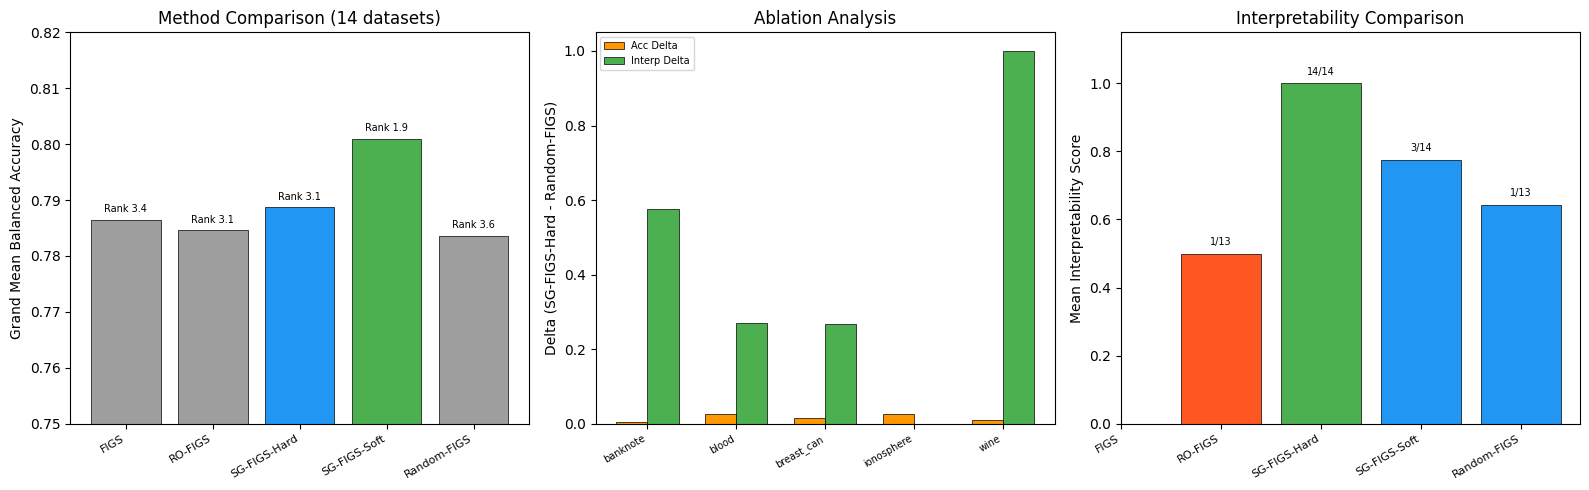

Figure saved to eval_summary.png


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- Plot 1: Grand Mean BA + Average Rank ---
ax1 = axes[0]
method_names = [METHOD_LABELS[m] for m in METHODS_5]
ba_vals = [metrics[f"grand_mean_ba_{m}"] for m in METHODS_5]
rank_vals = [metrics[f"avg_rank_{m}"] for m in METHODS_5]
colors = ["#4CAF50" if m == "sg_figs_soft" else "#2196F3" if "sg_figs" in m else "#9E9E9E" for m in METHODS_5]

bars = ax1.bar(range(len(method_names)), ba_vals, color=colors, edgecolor="black", linewidth=0.5)
ax1.set_xticks(range(len(method_names)))
ax1.set_xticklabels(method_names, rotation=30, ha="right", fontsize=8)
ax1.set_ylabel("Grand Mean Balanced Accuracy")
ax1.set_title("Method Comparison (14 datasets)")
ax1.set_ylim(0.75, 0.82)
for i, (bar, rank) in enumerate(zip(bars, rank_vals)):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.001,
             f"Rank {rank:.1f}", ha="center", va="bottom", fontsize=7)

# --- Plot 2: Ablation deltas ---
ax2 = axes[1]
abl_datasets = abl_df["Dataset"].values
acc_deltas = abl_df["Acc Delta"].values
interp_deltas = abl_df["Interp Delta"].values

x = np.arange(len(abl_datasets))
width = 0.35
bars1 = ax2.bar(x - width/2, acc_deltas, width, label="Acc Delta", color="#FF9800", edgecolor="black", linewidth=0.5)
bars2 = ax2.bar(x + width/2, interp_deltas, width, label="Interp Delta", color="#4CAF50", edgecolor="black", linewidth=0.5)
ax2.axhline(y=0, color="black", linewidth=0.5, linestyle="--")
ax2.set_xticks(x)
ax2.set_xticklabels([d[:10] for d in abl_datasets], rotation=30, ha="right", fontsize=7)
ax2.set_ylabel("Delta (SG-FIGS-Hard - Random-FIGS)")
ax2.set_title("Ablation Analysis")
ax2.legend(fontsize=7)

# --- Plot 3: Interpretability scores ---
ax3 = axes[2]
interp_methods = interp_df["Method"].values
interp_means = interp_df["Mean Interp."].values
# Replace None with 0 for plotting
interp_means_plot = [v if v is not None else 0 for v in interp_means]
perfect_counts = interp_df["Perfect (=1.0)"].values
n_datasets_arr = interp_df["N Datasets"].values

interp_colors = ["#4CAF50" if v == 1.0 else "#2196F3" if v and v > 0.5 else "#FF5722" for v in interp_means]
bars3 = ax3.bar(range(len(interp_methods)), interp_means_plot, color=interp_colors, edgecolor="black", linewidth=0.5)
ax3.set_xticks(range(len(interp_methods)))
ax3.set_xticklabels(interp_methods, rotation=30, ha="right", fontsize=8)
ax3.set_ylabel("Mean Interpretability Score")
ax3.set_title("Interpretability Comparison")
ax3.set_ylim(0, 1.15)
for i, (bar, pc, nd) in enumerate(zip(bars3, perfect_counts, n_datasets_arr)):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
             f"{pc}/{nd}", ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.savefig("eval_summary.png", dpi=150, bbox_inches="tight")
plt.show()
print("Figure saved to eval_summary.png")